# AUEB M.Sc. in Data Science (part-time)

### 2024.04 - 2024.06

## PART 06
### EXERCISE 02: POS Tagging with transformers

**Course**: Text Analytics   
**Authors**:
Anagnos Theodoros (p3352323) -
Michalopoulos Ioannis (p3352314) -
Kafantaris Panagiotis (p3352328) -  
Vigkos Ioannis (p3352326)

**Date**: 2024-06-04

In [ ]:
#@title <b>Time Out Preventer (Advanced) </b></strong>
%%capture
AUTO_RECONNECT = True #@param {type:"boolean"}
#@markdown **Run this code to prevent Google Colab from Timeout**
from os import makedirs
makedirs("/root/.config/rclone", exist_ok = True)
if AUTO_RECONNECT:
  import IPython
  from google.colab import output

  display(IPython.display.Javascript('''
  function ClickConnect(){
    btn = document.querySelector("colab-connect-button")
    if (btn != null){
      console.log("Click colab-connect-button");
      btn.click()
      }

    btn = document.getElementById('ok')
    if (btn != null){
      console.log("Click reconnect");
      btn.click()
      }
    }

  setInterval(ClickConnect,60000)
  '''))

In [ ]:
!pip install tensorflow==2.15.0

In [ ]:
!nvidia-smi

Sat Jun 15 13:02:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install conllu

### Libraries

In [ ]:
## Data Handling and Parsing
import os
from conllu import parse
import requests
from collections import Counter
import numpy as np

## Word Embeddings
import gensim.downloader as api

## Preprocessing
from nltk.util import ngrams
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split  # Importing train_test_split

## Metrics and Evaluation
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.exceptions import UndefinedMetricWarning

## Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, add, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.regularizers import l2

## Plotting
import matplotlib.pyplot as plt

## Other
import warnings

### Functions

In [ ]:
# Function for downloading dataset
def download_dataset(url, filename):
    response = requests.get(url)
    with open(filename, "wb") as f:
        f.write(response.content)

In [ ]:
# Function for parsing conllu files and extracting sentences
def parse_conllu(file_path):
    """
    Parsed the given conllu file and extracted sentences using the 'conllu' library.
    """
    # Opening the file in read mode with UTF-8 encoding
    with open(file_path, "r", encoding="utf-8") as f:
        # Reading the entire content of the file
        data = f.read()
        # Parsing the data to extract sentences using the 'conllu' library
        sentences = parse(data)
    # Returning the list of parsed sentences
    return sentences

In [ ]:
# Function for extracting words and tags from parsed sentences
def extract_words_and_tags(sentences):
    """
    Extracted words and corresponding POS tags from parsed sentences.
    """
    words = []
    tags = []
    # Iterating over each parsed sentence
    for sentence in sentences:
        sentence_words = []
        sentence_tags = []
        # Iterating over each token in the sentence
        for token in sentence:
            if token['form'] and token['upostag']:
                sentence_words.append(token['form'])  # Extracting the word form
                sentence_tags.append(token['upostag'])  # Extracting the POS tag
        # Appending the extracted words and tags to their respective lists
        words.append(sentence_words)
        tags.append(sentence_tags)
    # Returning the lists of words and tags
    return words, tags

### Metrics

In [ ]:
# Custom callback for additional metrics
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        # Initializing the callback with validation data
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        # Predicting on the validation data at the end of each epoch
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        # Extracting the true labels from the validation data
        val_targ = np.argmax(self.validation_data[1], -1)

        # Calculating the weighted F1 score for the validation data
        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=0)
        # Calculating the weighted recall score for the validation data
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=0)
        # Calculating the weighted precision score for the validation data
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=0)

        # Logging the calculated metrics
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision

        # Printing the calculated metrics
        print(f" — val_f1: {_val_f1:.4f} — val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f}")
        return

## Data Preprocessing

### Downloading the dataset and parsing the conllu files to extract sentences, words, and POS tags

In [ ]:
# Defining URLs of the datasets for training, development, and testing
urls = {
    "train": "https://github.com/UniversalDependencies/UD_English-EWT/raw/master/en_ewt-ud-train.conllu"
}

In [ ]:
# Downloading the training dataset and saving it locally
for key, url in urls.items():
    filename = f"en_ewt_{key}.conllu"
    download_dataset(url, filename)

Parsed the training, development, and test datasets to extract words and POS tags. Converted all words to lowercase for consistency and printed sample data for verification.

In [ ]:
# Parsing the training dataset
train_sentences = parse_conllu("en_ewt_train.conllu")

# Printing sample parsed sentences for verification
print("Sample parsed sentences from training data:")
print(train_sentences[0:5])
print("\n")

# Extracting words and tags from the parsed sentences
all_words, all_tags = extract_words_and_tags(train_sentences)

# Splitting the dataset into train, development, and test sets (70-15-15 ratio)
train_words, temp_words, train_tags, temp_tags = train_test_split(all_words, all_tags, test_size=0.3, random_state=42)
dev_words, test_words, dev_tags, test_tags = train_test_split(temp_words, temp_tags, test_size=0.5, random_state=42)

# Printing the sizes of the datasets
print("Size of train_words:", len(train_words))
print("Size of dev_words:", len(dev_words))
print("Size of test_words:", len(test_words))
print("\n")
print("Size of train_tags:", len(train_tags))
print("Size of dev_tags:", len(dev_tags))
print("Size of test_tags:", len(test_tags))
print("\n")

Sample parsed sentences from training data:
[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, ., metadata={newdoc id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000", sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0001", newpar id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-p0001", text: "Al-Zaman : American forces killed Shaikh Abdullah al-Ani, the preacher at the mosque in the town of Qaim, near the Syrian border."}>, TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ], metadata={sent_id: "weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000-0002", text: "[This killing of a respected cleric will be causing us trouble for years to come.]"}>, TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terro

In [ ]:
from tqdm import tqdm

# clean the corpus
def preprocess(corpus):
    corpus_tokenized = []
    for doc in tqdm(corpus):
        doc = ' '.join(doc)
        doc = nlp(doc)
        tokens = []
        for sent in doc.sents:
            for tok in sent:
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or \
                   tok.text.lower() in STOP_WORDS or tok.text in string.punctuation or \
                   all(x in string.punctuation for x in tok.text) or is_number(tok.text):
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"', "'").strip().lower())
        corpus_tokenized.append(tokens)
    return corpus_tokenized

In [ ]:
# Flatten the list
flattened_tags = [tag for sublist in all_tags for tag in sublist]

# Get unique values
unique_tags = set(flattened_tags)

# Convert set to a sorted list
sorted_unique_tags = sorted(unique_tags)

# Print unique values with their IDs
for idx, tag in enumerate(sorted_unique_tags):
    print(f"{idx}: {tag}")

0: ADJ
1: ADP
2: ADV
3: AUX
4: CCONJ
5: DET
6: INTJ
7: NOUN
8: NUM
9: PART
10: PRON
11: PROPN
12: PUNCT
13: SCONJ
14: SYM
15: VERB
16: X
17: _


In [ ]:
# Convert tags to their corresponding IDs for each list in train_tags
train_tags_ids = [[sorted_unique_tags.index(tag) for tag in tags] for tags in train_tags]
dev_tags_ids = [[sorted_unique_tags.index(tag) for tag in tags] for tags in dev_tags]
test_tags_ids = [[sorted_unique_tags.index(tag) for tag in tags] for tags in test_tags]

In [ ]:
for i in range(len(train_words[1])):
  print(train_words[1][i],' : ',train_tags[1][i],' : ',train_tags_ids[1][i])

I  :  PRON  :  10
was  :  AUX  :  3
not  :  PART  :  9
happy  :  ADJ  :  0
with  :  ADP  :  1
the  :  DET  :  5
way  :  NOUN  :  7
they  :  PRON  :  10
looked  :  VERB  :  15
,  :  PUNCT  :  12
very  :  ADV  :  2
wavy  :  ADJ  :  0
,  :  PUNCT  :  12
uneven  :  ADJ  :  0
edges  :  NOUN  :  7
,  :  PUNCT  :  12
and  :  CCONJ  :  4
with  :  ADP  :  1
the  :  DET  :  5
exception  :  NOUN  :  7
of  :  ADP  :  1
1  :  NUM  :  8
,  :  PUNCT  :  12
there  :  PRON  :  10
is  :  VERB  :  15
a  :  DET  :  5
dip  :  NOUN  :  7
in  :  ADP  :  1
the  :  DET  :  5
center  :  NOUN  :  7
of  :  ADP  :  1
each  :  DET  :  5
nail  :  NOUN  :  7
.  :  PUNCT  :  12


In [ ]:
def create_dictionary(tokens, tags,tags_ids):
    examples = {
        "tokens": tokens,
        "tags": tags,
        "tags_ids":tags_ids
    }
    return examples

In [ ]:
train_data_dict = create_dictionary(train_words,train_tags,train_tags_ids)
dev_data_dict = create_dictionary(dev_words,dev_tags,dev_tags_ids)
test_data_dict = create_dictionary(test_words,test_tags,test_tags_ids)

In [ ]:
for i in range(len(train_data_dict['tokens'][1])):
    print(train_data_dict['tokens'][1][i], ' : ',train_data_dict['tags'][1][i], ' : ',train_data_dict['tags_ids'][1][i] )

I  :  PRON  :  10
was  :  AUX  :  3
not  :  PART  :  9
happy  :  ADJ  :  0
with  :  ADP  :  1
the  :  DET  :  5
way  :  NOUN  :  7
they  :  PRON  :  10
looked  :  VERB  :  15
,  :  PUNCT  :  12
very  :  ADV  :  2
wavy  :  ADJ  :  0
,  :  PUNCT  :  12
uneven  :  ADJ  :  0
edges  :  NOUN  :  7
,  :  PUNCT  :  12
and  :  CCONJ  :  4
with  :  ADP  :  1
the  :  DET  :  5
exception  :  NOUN  :  7
of  :  ADP  :  1
1  :  NUM  :  8
,  :  PUNCT  :  12
there  :  PRON  :  10
is  :  VERB  :  15
a  :  DET  :  5
dip  :  NOUN  :  7
in  :  ADP  :  1
the  :  DET  :  5
center  :  NOUN  :  7
of  :  ADP  :  1
each  :  DET  :  5
nail  :  NOUN  :  7
.  :  PUNCT  :  12


In [ ]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
tokenized_input = tokenizer(train_data_dict['tokens'][1], is_split_into_words=True)
token_ids = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
word_ids = tokenized_input.word_ids()

assert (len(word_ids) == len(token_ids)), "ERROR"

for tok_id,w_id in zip(token_ids,word_ids):
  if w_id != None:
    print("Token: {} Subtoken: {} Word_id: {}".format(train_data_dict['tokens'][1][w_id],tok_id,w_id))
  else:
    print("Token: {} | Subtoken: {} | Word_id: {}".format(None,tok_id,w_id))
  print("--")



Token: None | Subtoken: [CLS] | Word_id: None
--
Token: I Subtoken: i Word_id: 0
--
Token: was Subtoken: was Word_id: 1
--
Token: not Subtoken: not Word_id: 2
--
Token: happy Subtoken: happy Word_id: 3
--
Token: with Subtoken: with Word_id: 4
--
Token: the Subtoken: the Word_id: 5
--
Token: way Subtoken: way Word_id: 6
--
Token: they Subtoken: they Word_id: 7
--
Token: looked Subtoken: looked Word_id: 8
--
Token: , Subtoken: , Word_id: 9
--
Token: very Subtoken: very Word_id: 10
--
Token: wavy Subtoken: wavy Word_id: 11
--
Token: , Subtoken: , Word_id: 12
--
Token: uneven Subtoken: uneven Word_id: 13
--
Token: edges Subtoken: edges Word_id: 14
--
Token: , Subtoken: , Word_id: 15
--
Token: and Subtoken: and Word_id: 16
--
Token: with Subtoken: with Word_id: 17
--
Token: the Subtoken: the Word_id: 18
--
Token: exception Subtoken: exception Word_id: 19
--
Token: of Subtoken: of Word_id: 20
--
Token: 1 Subtoken: 1 Word_id: 21
--
Token: , Subtoken: , Word_id: 22
--
Token: there Subtoken: th

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"tags_ids"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# !pip install datasets
# !pip install pyarrow vaex
# !pip install pyarrow==15.0.0
# !pip install datasets==2.20.0

In [ ]:
# !pip install pyarrow==8.0.0
# !pip install datasets

  Using cached pyarrow-8.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (29.4 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 16.1.0
    Uninstalling pyarrow-16.1.0:
      Successfully uninstalled pyarrow-16.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 8.0.0 which is incompatible.
datasets 2.20.0 requires pyarrow>=15.0.0, but you have pyarrow 8.0.0 which is incompatible.


  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 8.0.0
    Uninstalling pyarrow-8.0.0:
      Successfully uninstalled pyarrow-8.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


In [ ]:
from datasets import Dataset

# Convert the dictionary to a Dataset object
train_dataset = Dataset.from_dict(train_data_dict)
dev_dataset = Dataset.from_dict(dev_data_dict)
test_dataset = Dataset.from_dict(test_data_dict)


In [ ]:
tokenized_dev_dataset = dev_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

Map:   0%|          | 0/8780 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
label_list=sorted_unique_tags

In [ ]:
! pip install torch torchvision torchaudio

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list)).to("cuda")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# !pip install accelerate==0.21.0
# !pip install transformers[torch]
!pip install transformers -U

In [ ]:
from transformers import TrainingArguments

In [ ]:
pip install accelerate -U

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir='./logs',
    warmup_steps=100,
    eval_steps=300,
    save_steps=300,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    save_total_limit = 1
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_dev_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
300,No log,0.104937
600,0.360100,0.080680
900,0.360100,0.076602
1200,0.052200,0.074134
1500,0.020800,0.072137


TrainOutput(global_step=1647, training_loss=0.132813868988769, metrics={'train_runtime': 473.8119, 'train_samples_per_second': 55.592, 'train_steps_per_second': 3.476, 'total_flos': 721879540214976.0, 'train_loss': 0.132813868988769, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.07213663309812546,
 'eval_runtime': 7.7699,
 'eval_samples_per_second': 242.218,
 'eval_steps_per_second': 3.861,
 'epoch': 3.0}

In [ ]:
id2tag = {id: tag for id, tag in enumerate(label_list)}

In [ ]:
id2tag

{0: 'ADJ',
 1: 'ADP',
 2: 'ADV',
 3: 'AUX',
 4: 'CCONJ',
 5: 'DET',
 6: 'INTJ',
 7: 'NOUN',
 8: 'NUM',
 9: 'PART',
 10: 'PRON',
 11: 'PROPN',
 12: 'PUNCT',
 13: 'SCONJ',
 14: 'SYM',
 15: 'VERB',
 16: 'X',
 17: '_'}

In [ ]:
def get_raw_tokens(subtokens: list[str]) -> list[str]:

  tokens = []
  for tok in subtokens:
      if tok.startswith("##"):
          tokens[-1] += tok[2:]
      else:
          tokens.append(tok)
  return tokens

In [ ]:
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)


def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, truncation=True, return_tensors="pt").to("cuda")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0][0].softmax(1)
    # executing argmax function to get the candidate tags
    word_ids = inputs.word_ids()
    raw_tokens = get_raw_tokens([tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])][0])[1:-1]
    tags = ([id2tag[x] for x in probs.cpu().detach().numpy().argmax(axis=1).tolist()])
    assert len(word_ids) == len(tags), "ERROR"
    f_tags = []
    for idx in range(len(raw_tokens)):
      f_tags.append(tags[word_ids.index(idx)])


    tokens_n_tags = [(tok,tag) for tok,tag in zip(raw_tokens, f_tags)]

    return pd.DataFrame(tokens_n_tags, columns=['token', 'tag'])

## Examples

In [ ]:
# Example #1
text1 = """
President Joe Biden is "fine" after tripping and falling over at an event in
Colorado, White House officials say."""

print(get_prediction(text1))

        token    tag
0   president  PROPN
1         joe  PROPN
2       biden  PROPN
3          is    AUX
4           "  PUNCT
5        fine    ADJ
6           "  PUNCT
7       after  SCONJ
8    tripping   VERB
9         and  CCONJ
10    falling   VERB
11       over    ADV
12         at    ADP
13         an    DET
14      event   NOUN
15         in    ADP
16   colorado  PROPN
17          ,  PUNCT
18      white    ADJ
19      house  PROPN
20  officials   NOUN
21        say   VERB
22          .  PUNCT


In [ ]:
# Example #2
text2 = """
Apple in October 2021 overhauled the high-end MacBook Pro, introducing
an entirely new design, new chips, new capabilities, and more."""

print(get_prediction(text2))

           token    tag
0          apple  PROPN
1             in    ADP
2        october  PROPN
3           2021    NUM
4     overhauled   VERB
5            the    DET
6           high    ADJ
7              -  PUNCT
8            end   NOUN
9        macbook  PROPN
10           pro  PROPN
11             ,  PUNCT
12   introducing   VERB
13            an    DET
14      entirely    ADV
15           new    ADJ
16        design   NOUN
17             ,  PUNCT
18           new    ADJ
19         chips   NOUN
20             ,  PUNCT
21           new    ADJ
22  capabilities   NOUN
23             ,  PUNCT
24           and  CCONJ
25          more    ADJ
26             .  PUNCT


## Hyperparamt tuning

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification, TrainerCallback

# Custom callback to log training and validation metrics
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.train_acc = []
        self.eval_acc = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append(logs["loss"])
            if "eval_loss" in logs:
                self.eval_loss.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.eval_acc.append(logs["eval_accuracy"])
            if "accuracy" in logs:
                self.train_acc.append(logs["accuracy"])


In [ ]:
import optuna
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification

# Define a function to create a model and trainer with specific hyperparameters
def model_init():
    return AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(unique_tags)).to("cuda")

def objective(trial):
    # Define the hyperparameters to tune with an emphasis on speed
    learning_rate = trial.suggest_float("learning_rate", 8e-5, 1e-4, log=True)  # Increased range for learning rate
    num_train_epochs = trial.suggest_int("num_train_epochs", 1, 3)  # Fewer epochs
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [32, 64])  # Larger batch size

    # Set up the training arguments with the suggested hyperparameters
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=64,
        weight_decay=0.01,
        logging_dir='./logs',
        report_to="none",  # Disable TensorBoard logging
        warmup_steps=100,  # Reduced warmup steps
        evaluation_strategy="steps",
        eval_steps=300,  # Less frequent evaluation
        save_steps=300,  # Less frequent saving
        load_best_model_at_end=True,
        save_total_limit=2  # Reduced total saved models
    )

    # Initialize the trainer
    logging_callback = LoggingCallback()
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[logging_callback]
    )

    # Train the model and return the evaluation metric
    trainer.train()
    eval_result = trainer.evaluate()
    return eval_result["eval_loss"]

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)


# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_hparams = study.best_params

# Set up the training arguments with the best hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_hparams["num_train_epochs"],
    learning_rate=best_hparams["learning_rate"],
    per_device_train_batch_size=best_hparams["per_device_train_batch_size"],
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none",  # Disable TensorBoard logging
    warmup_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,  # Less frequent evaluation
    save_steps=100,
    load_best_model_at_end=True,
    save_total_limit=1
)

# Best hyperparameters:  {'learning_rate': 9.531350385721654e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}

# Initialize the trainer with the best hyperparameters
logging_callback = LoggingCallback()
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_dev_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[logging_callback]
)

# Train the final model
trainer.train()

# Evaluate the final model on the development set
eval_results = trainer.evaluate()
print("Evaluation results: ", eval_results)

[I 2024-06-15 13:11:52,846] A new study created in memory with name: no-name-e564beaa-561a-4b30-ae2e-fba5dba144e7
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
300,No log,0.072218


[I 2024-06-15 13:18:09,733] Trial 0 finished with value: 0.07221844792366028 and parameters: {'learning_rate': 9.893783889060243e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.07221844792366028.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to 

Step,Training Loss,Validation Loss
300,No log,0.071780


[I 2024-06-15 13:24:21,372] Trial 1 finished with value: 0.07177998870611191 and parameters: {'learning_rate': 8.007553739160411e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.07177998870611191.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to 

Step,Training Loss,Validation Loss


[I 2024-06-15 13:27:53,868] Trial 2 finished with value: 0.07092352956533432 and parameters: {'learning_rate': 9.615034491606915e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 64}. Best is trial 2 with value: 0.07092352956533432.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Best hyperparameters:  {'learning_rate': 9.615034491606915e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 64}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
100,No log,0.122099
200,No log,0.078341


Evaluation results:  {'eval_loss': 0.07834108918905258, 'eval_runtime': 7.4299, 'eval_samples_per_second': 253.299, 'eval_steps_per_second': 4.038, 'epoch': 2.0}


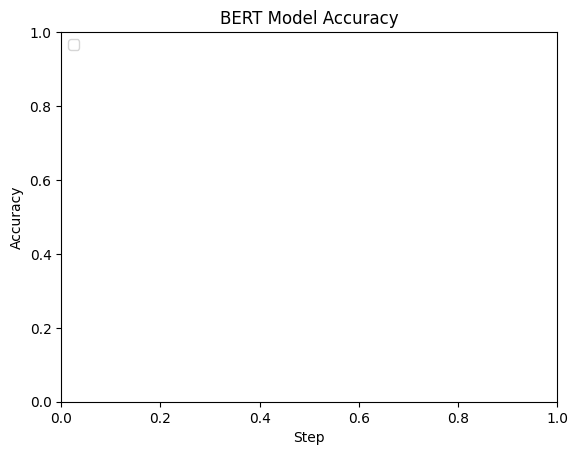

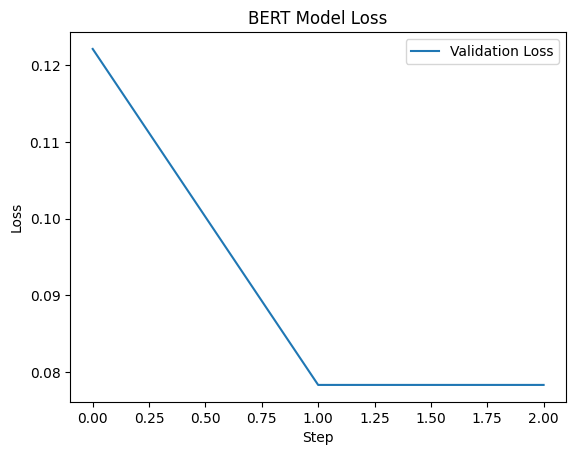

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure()
if logging_callback.train_acc:
    plt.plot(logging_callback.train_acc, label='Train Accuracy')
if logging_callback.eval_acc:
    plt.plot(logging_callback.eval_acc, label='Validation Accuracy')
plt.title('BERT Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Step')
plt.legend(loc='upper left')
plt.savefig('accuracy_plot.png')  # Save the plot as an image
plt.show()

# Plotting training and validation loss
plt.figure()
if logging_callback.train_loss:
    plt.plot(logging_callback.train_loss, label='Train Loss')
if logging_callback.eval_loss:
    plt.plot(logging_callback.eval_loss, label='Validation Loss')
plt.title('BERT Model Loss')
plt.ylabel('Loss')
plt.xlabel('Step')
plt.legend(loc='upper right')
plt.savefig('loss_plot.png')  # Save the plot as an image
plt.show()


In [ ]:
print("Training Accuracy:", logging_callback.train_acc)
print("Validation Accuracy:", logging_callback.eval_acc)
print("Training Loss:", logging_callback.train_loss)
print("Validation Loss:", logging_callback.eval_loss)


Training Accuracy: []
Validation Accuracy: []
Training Loss: []
Validation Loss: [0.12209877371788025, 0.07834108918905258, 0.07834108918905258]


### Evaluation in Test Dataset

In [ ]:
tokenized_test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1882 [00:00<?, ? examples/s]

In [ ]:
# Use the trainer to make predictions
predictions, labels, _ = trainer.predict(tokenized_test_dataset)

# Convert predictions to tag names
predicted_tag_ids = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens) from predictions and labels
true_labels = [[label for label, mask in zip(label_seq, label_seq != -100) if mask] for label_seq in labels]
predicted_labels = [[pred for pred, mask in zip(pred_seq, label_seq != -100) if mask] for pred_seq, label_seq in zip(predicted_tag_ids, labels)]

# Flatten the lists to get all tokens together
true_labels_flat = [label for sublist in true_labels for label in sublist]
predicted_labels_flat = [label for sublist in predicted_labels for label in sublist]

# Map the tag IDs back to the original tag names
true_tag_names = [sorted_unique_tags[label] for label in true_labels_flat]
predicted_tag_names = [sorted_unique_tags[label] for label in predicted_labels_flat]

# Generate classification report
report = classification_report(true_tag_names, predicted_tag_names, labels=sorted_unique_tags, target_names=sorted_unique_tags)
print(report)

              precision    recall  f1-score   support

         ADJ       0.96      0.96      0.96      1947
         ADP       0.98      0.98      0.98      2654
         ADV       0.96      0.95      0.95      1539
         AUX       1.00      0.99      1.00      1951
       CCONJ       0.99      1.00      1.00       946
         DET       1.00      0.99      1.00      2448
        INTJ       0.88      0.95      0.92       125
        NOUN       0.97      0.97      0.97      5159
         NUM       0.98      0.99      0.99       589
        PART       1.00      0.99      0.99       879
        PRON       1.00      1.00      1.00      2741
       PROPN       0.94      0.94      0.94      1834
       PUNCT       1.00      1.00      1.00      3523
       SCONJ       0.95      0.95      0.95       580
         SYM       0.91      0.90      0.90        97
        VERB       0.98      0.99      0.99      3313
           X       1.00      0.15      0.26        47
           _       0.99    

## Extra Bonus

In [ ]:
sample_test_words = [
    ["Sara"],
    ["Vince"],
    ["The", "invasion", "of", "Iraq", "provided", "marvelous", "political", "cover", "for", "the", "GOP", "not", "only", "during", "those", "midterms", ",", "but", "during", "the", "2004", "Presidential", "election", "."],
    ["Smutney", "-", "Jones", "also", "said", "he", "was", "unaware", "of", "anyone", "in", "the", "power", "-", "generating", "community", "being", "consulted", "."],
    ["If", "you", "have", "any", "comments", ",", "please", "let", "me", "know", "."],
    ["Now", ",", "of", "course", ",", "there's", "there", "'s", "a", "new", "building", ",", "with", "presumably", "better", "facilities", "."],
    ["Chris"],
    ["He's", "He", "'s", "not", "putting", "it", "back", "on", "."],
    ["It", "simply", "refers", "to", "the", "same", "ICC", "publication", "for", "the", "transfer", "process", "that", "governs", "the", "letter", "of", "credit", "generally", "."],
    ["His", "one", "-", "day", "mission", "vaulted", "his", "communist", "homeland", "into", "the", "elite", "circle", "of", "spacefaring", "nations", "-", "Russia", "and", "the", "United", "States", "-", "that", "can", "launch", "and", "sustain", "humans", "in", "space", "."]
]

sample_test_tags = [
    ["PROPN"],
    ["PROPN"],
    ["DET", "NOUN", "ADP", "PROPN", "VERB", "ADJ", "ADJ", "NOUN", "ADP", "DET", "PROPN", "PART", "ADV", "ADP", "DET", "NOUN", "PUNCT", "CCONJ", "ADP", "DET", "NUM", "ADJ", "NOUN", "PUNCT"],
    ["PROPN", "PUNCT", "PROPN", "ADV", "VERB", "PRON", "AUX", "ADJ", "SCONJ", "PRON", "ADP", "DET", "NOUN", "PUNCT", "NOUN", "NOUN", "AUX", "VERB", "PUNCT"],
    ["SCONJ", "PRON", "VERB", "DET", "NOUN", "PUNCT", "INTJ", "VERB", "PRON", "VERB", "PUNCT"],
    ["ADV", "PUNCT", "ADP", "NOUN", "PUNCT", "_", "PRON", "VERB", "DET", "ADJ", "NOUN", "PUNCT", "ADP", "ADV", "ADJ", "NOUN", "PUNCT"],
    ["PROPN"],
    ["_", "PRON", "AUX", "PART", "VERB", "PRON", "ADV", "ADV", "PUNCT"],
    ["PRON", "ADV", "VERB", "ADP", "DET", "ADJ", "NOUN", "NOUN", "ADP", "DET", "NOUN", "NOUN", "PRON", "VERB", "DET", "NOUN", "ADP", "NOUN", "ADV", "PUNCT"],
    ["PRON", "NUM", "PUNCT", "NOUN", "NOUN", "VERB", "PRON", "ADJ", "NOUN", "ADP", "DET", "ADJ", "NOUN", "ADP", "ADJ", "NOUN", "PUNCT", "PROPN", "CCONJ", "DET", "ADJ", "PROPN", "PUNCT", "PRON", "AUX", "VERB", "CCONJ", "VERB", "NOUN", "ADP", "NOUN", "PUNCT"]
]


### Prompting

### Generate Predictions

In [ ]:
few_shot_prompt = """
You are a part-of-speech (POS) tagger. Given a sentence, you will provide the POS tags for each word.

Example 1:
Sentence: I love programming
Tags: PRON VERB NOUN

Example 2:
Sentence: She is reading a book
Tags: PRON VERB VERB DET NOUN

Example 3:
Sentence: The quick brown fox jumps over the lazy dog
Tags: DET ADJ ADJ NOUN VERB ADP DET ADJ NOUN

Now, please provide the POS tags for the following sentence:
"""

prompts = []
for i, words in enumerate(sample_test_words):
    sentence = " ".join(words)
    prompt = few_shot_prompt + f"\nSentence: {sentence}\nTags: "
    prompts.append(prompt)


In [ ]:
# !pip install torch transformers[torch] accelerate -U

In [ ]:
import torch

# Assuming your model and tokenizer are already loaded
tokenized_test_examples = tokenizer(sample_test_words, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True)
inputs = tokenized_test_examples['input_ids'].to('cuda')
attention_mask = tokenized_test_examples['attention_mask'].to('cuda')

with torch.no_grad():
    outputs = model(inputs, attention_mask=attention_mask)
    logits = outputs.logits

predicted_ids = torch.argmax(logits, dim=2).cpu().numpy()

# Convert predictions to tag names
predicted_tags = [[sorted_unique_tags[idx] for idx in pred_seq] for pred_seq in predicted_ids]

# Align predicted tags with words
aligned_predicted_tags = []
for words, tags in zip(sample_test_words, predicted_tags):
    aligned_tags = []
    for word, tag in zip(words, tags):
        if word:
            aligned_tags.append(tag)
    aligned_predicted_tags.append(aligned_tags)


In [ ]:
# Mock responses from ChatGPT
chatgpt_responses = [
    "PROPN",
    "PROPN",
    "DET NOUN ADP PROPN VERB ADJ ADJ NOUN ADP DET PROPN PART ADV ADP DET NOUN PUNCT CCONJ ADP DET NUM ADJ NOUN PUNCT",
    "PROPN PUNCT PROPN ADV VERB PRON AUX ADJ SCONJ PRON ADP DET NOUN PUNCT NOUN NOUN AUX VERB PUNCT",
    "SCONJ PRON VERB DET NOUN PUNCT INTJ VERB PRON VERB PUNCT",
    "ADV PUNCT ADP NOUN PUNCT _ PRON VERB DET ADJ NOUN PUNCT ADP ADV ADJ NOUN PUNCT",
    "PROPN",
    "_ PRON AUX PART VERB PRON ADV ADV PUNCT",
    "PRON ADV VERB ADP DET ADJ NOUN NOUN ADP DET NOUN NOUN PRON VERB DET NOUN ADP NOUN ADV PUNCT",
    "PRON NUM PUNCT NOUN NOUN VERB PRON ADJ NOUN ADP DET ADJ NOUN ADP ADJ NOUN PUNCT PROPN CCONJ DET ADJ PROPN PUNCT PRON AUX VERB CCONJ VERB NOUN ADP NOUN PUNCT"
]


In [ ]:
for i, (words, true_tags, pred_tags, chatgpt_tags) in enumerate(zip(sample_test_words, sample_test_tags, aligned_predicted_tags, chatgpt_responses)):
    print(f"Example {i+1}:")
    print("Words:", words)
    print("Ground Truth Tags:", true_tags)
    print("Predicted Tags (Model):", pred_tags)
    print("Predicted Tags (ChatGPT):", chatgpt_tags)


Example 1:
Words: ['Sara']
Ground Truth Tags: ['PROPN']
Predicted Tags (Model): ['PUNCT']
Predicted Tags (ChatGPT): PROPN
Example 2:
Words: ['Vince']
Ground Truth Tags: ['PROPN']
Predicted Tags (Model): ['PUNCT']
Predicted Tags (ChatGPT): PROPN
Example 3:
Words: ['The', 'invasion', 'of', 'Iraq', 'provided', 'marvelous', 'political', 'cover', 'for', 'the', 'GOP', 'not', 'only', 'during', 'those', 'midterms', ',', 'but', 'during', 'the', '2004', 'Presidential', 'election', '.']
Ground Truth Tags: ['DET', 'NOUN', 'ADP', 'PROPN', 'VERB', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'PART', 'ADV', 'ADP', 'DET', 'NOUN', 'PUNCT', 'CCONJ', 'ADP', 'DET', 'NUM', 'ADJ', 'NOUN', 'PUNCT']
Predicted Tags (Model): ['PUNCT', 'DET', 'NOUN', 'ADP', 'PROPN', 'VERB', 'ADJ', 'ADJ', 'NOUN', 'ADP', 'DET', 'PROPN', 'PROPN', 'PART', 'ADV', 'ADP', 'DET', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'CCONJ', 'ADP', 'DET']
Predicted Tags (ChatGPT): DET NOUN ADP PROPN VERB ADJ ADJ NOUN ADP DET PROPN PART ADV ADP DET NOUN PUNC